In [1]:
'''import pickle
import json

with open(r"final_beam_shaper_design_manuel.json", "r") as f:
    final_bs_manuel = json.load(f)
    
final_bs_manuel

from optiland.optic import Optic

final_bs_manuel = Optic.from_dict(final_bs_manuel)

final_bs_manuel.info()'''

'import pickle\nimport json\n\nwith open(r"final_beam_shaper_design_manuel.json", "r") as f:\n    final_bs_manuel = json.load(f)\n\nfinal_bs_manuel\n\nfrom optiland.optic import Optic\n\nfinal_bs_manuel = Optic.from_dict(final_bs_manuel)\n\nfinal_bs_manuel.info()'

In [2]:
from __future__ import annotations
import pickle


with open(r"final_beam_shaper_S3_coeffs.pkl", "rb") as f:
    coeffs_S3 = pickle.load(f)
    
with open(r"final_beam_shaper_S5_coeffs.pkl", "rb") as f:
    coeffs_S5 = pickle.load(f)
    
# coeffs_S5

In [3]:
from optiland.optic import Optic
import optiland.backend as be
from optiland.materials import Material, IdealMaterial
from optiland.physical_apertures import RadialAperture, RectangularAperture
from optiland.rays import RealRays

import numpy as np
import torch
from scipy.stats.qmc import Sobol

be.set_backend("torch")
be.grad_mode.enable()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
be.set_device(DEVICE)

print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
STD_EVAL = dict(
    top_hat_radius=7.50,  # R0 (mm) (1/e^2 irradiance level)
    num_bins_analysis=201,  # 201 x 201
    num_analysis_rays=1_000_000,  # shared rays
    peak_irradiance=6.65e-3,  # W/mm^2 (0.00060)
    falloff_steepness=16,  # p
    alpha_threshold=0.999,  # rigorous mask threshold
    wavelength_um=1.55,
    # Source parameters
    mfd_um=10.4,  # Mode field diameter in µm (MFD = 2 * w0)
    divergence_deg_1_e2=(1.55 / (np.pi * 5.2))
    * (180 / np.pi)
    * 2,  # Full divergence angle (1/e²) in degrees
)

In [5]:
class ExtendedGaussianSource:
    """
    Generates a high-quality, extended Gaussian beam with both spatial and
    angular distributions, using Sobol sequences.
    """

    def __init__(
        self,
        mfd_um: float,
        divergence_deg_1_e2: float,
        wavelength_um: float,
        total_power: float = 1.0,
        device: str = "cpu",
        is_point_source: bool = False,
    ):
        self.wavelength = wavelength_um
        self.total_power = total_power
        self.device = device
        self.sqrt2 = torch.tensor(np.sqrt(2.0), dtype=torch.float32, device=self.device)
        self.is_point_source = is_point_source

        # Spatial sigma for importance sampling
        w0_um = mfd_um / 2.0  # w₀ is the 1/e² radius
        self.sigma_spatial_mm = (w0_um * 1e-3) / 2.0

        # Angular sigma for importance sampling
        theta_rad = np.radians(divergence_deg_1_e2 / 2.0)
        self.sigma_angular_rad = theta_rad / 2.0

    def generate_rays(self, num_rays: int) -> RealRays:
        if num_rays <= 0:
            raise ValueError("num_rays must be a positive integer.")

        # Round up to nearest power of 2 (required for Sobol sampling)
        num_samples = 1 << (num_rays - 1).bit_length()
        sampler = Sobol(d=4, scramble=True)
        u_numpy = sampler.random(n=num_samples)
        u = torch.from_numpy(u_numpy).float().to(self.device)

        if self.is_point_source:
            # For point source, set spatial coordinates to zero
            x_start = torch.zeros(num_samples, device=self.device)
            y_start = torch.zeros(num_samples, device=self.device)
        else:
            # Convert uniform samples to a Gaussian distribution in phase space
            x_start = self.sigma_spatial_mm * self.sqrt2 * torch.erfinv(2 * u[:, 0] - 1)
            y_start = self.sigma_spatial_mm * self.sqrt2 * torch.erfinv(2 * u[:, 1] - 1)

        # sample non-paraxial angles
        theta_x = self.sigma_angular_rad * self.sqrt2 * torch.erfinv(2 * u[:, 2] - 1)
        theta_y = self.sigma_angular_rad * self.sqrt2 * torch.erfinv(2 * u[:, 3] - 1)
        tau_x = torch.tan(theta_x)
        tau_y = torch.tan(theta_y)
        # direction cosines for tracing in optiland, taken from slopes
        N_initial = 1.0 / torch.sqrt(1.0 + tau_x**2 + tau_y**2)
        L_initial = tau_x * N_initial
        M_initial = tau_y * N_initial

        num_valid_rays = L_initial.shape[0]

        if num_valid_rays == 0:
            raise ValueError("No valid rays generated. Try increasing num_rays.")

        print(f"Generated {num_valid_rays} valid rays (from {num_samples} samples).")

        z_start = torch.zeros(num_valid_rays, device=self.device)

        unnormalized_power = torch.ones_like(N_initial)
        total_unnormalized_power = torch.sum(unnormalized_power)

        if total_unnormalized_power > 1e-9:
            normalization_factor = self.total_power / total_unnormalized_power
        else:
            normalization_factor = 0.0

        intensity = unnormalized_power * normalization_factor
        wavelength = torch.full((num_valid_rays,), self.wavelength, device=self.device)

        return RealRays(
            x=x_start.detach(),
            y=y_start.detach(),
            z=z_start.detach(),
            L=L_initial.detach(),
            M=M_initial.detach(),
            N=N_initial.detach(),
            intensity=intensity,
            wavelength=wavelength,
        )

In [6]:

# --- Create the optical system ---
class CompleteSystemSPD(Optic):
    """We can define our optical system here, and can be called from other scripts"""

    def __init__(self, coeffs_S3, coeffs_S5):
        self.coeffs_S3 = coeffs_S3
        self.coeffs_S5 = coeffs_S5
        super().__init__()

        # System Settings (Wvls, aperture, etc)
        ## ---- Aperture ----
        self.set_aperture(aperture_type="objectNA", value=0.15 )

        ## ---- Fields ----
        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        ## ---- Wavelengths ----
        # self.add_wavelength(value=1.53)
        self.add_wavelength(value=1.55, is_primary=True)
        # self.add_wavelength(value=1.56)

        # Materials to be used
        H_K3 = Material("H-K3", reference="cdgm")
        H_ZLAF68C = Material("H-ZLAF68C", reference="cdgm")
        
        H_K9L = Material("H-K9L", reference="cdgm") # filter and dichroics
        
        H_ZF71GT = Material("H-ZF71GT", reference="cdgm")
        H_ZF72AGT = Material("H-ZF72AGT", reference="cdgm")
        H_ZBAF20 = Material("H-ZBAF20", reference="cdgm")
        H_ZPK5 = Material("H-ZPK5", reference="cdgm")

        # -- Lens Data Editor here --

        ## LDE Auxiliary data
        conic_S3 = -2.02271
        conic_S5 = -1.31459
        norm_radius_S3 = 5.5313
        norm_radius_S5 = 11.0210
        
        ap1 = RadialAperture(6.5) # semi-clear aperture
        ap2 = RadialAperture(9.0)
        apt_detector = RectangularAperture(-50, 50, -50, 50)
        ap3 = RadialAperture(15.0)
        ap4 = RadialAperture(53.0)

        self.add_surface(index=0, thickness=0.0)
        self.add_surface(index=1, thickness=26.5)
        self.add_surface(
            index=2,
            thickness=4.0,
            radius=np.inf,
            material="D-K9",
            aperture=ap1,
            is_stop=True,
        )  # S1
        self.add_surface(
            index=3,
            radius=33658.6,
            thickness=25.0,
            surface_type="forbes_qbfs",
            conic=conic_S3,
            radial_terms=coeffs_S3,
            norm_radius=norm_radius_S3,
            aperture=ap1,
        )  # S2
        self.add_surface(
            index=4, radius=np.inf, thickness=7, material="D-ZLAF52LA", aperture=ap2
        )  # S3
        self.add_surface(
            index=5,
            radius=-43.0005,
            thickness=108.0,
            surface_type="forbes_qbfs",
            conic=conic_S5,
            radial_terms=coeffs_S5,
            norm_radius=norm_radius_S5,
            aperture=ap2,
        )  # S4
        
        self.add_surface(index=6, thickness=12.045, radius=-19.08, material=H_ZF71GT, conic=-2.4498, coefficients=[0.0,8.2365e-5, 3.5232e-7, 4.9178e-9], surface_type="even_asphere", aperture=ap2) # BXP L1
        self.add_surface(index=7, thickness=12.049, radius=-44.4309, material=H_ZF72AGT, aperture=ap3)
        self.add_surface(index=8, thickness=12.023, radius=21.5893, material=H_ZBAF20, aperture=ap3)    
        self.add_surface(index=9, thickness=201.8785, radius=-41.0084, material="air", aperture=ap3)
        self.add_surface(index=10, thickness=12.0, radius=-1502.8819, material=H_ZPK5, aperture=ap4)  # BXP L2
        self.add_surface(index=11, thickness=50.0, radius=-152.2147, material="air", aperture=ap4) 
        
        self.add_surface(index=12, aperture=apt_detector)
        # self.add_surface(index=6)  # image


In [7]:
with torch.no_grad():    
    emitter = CompleteSystemSPD(coeffs_S3, coeffs_S5)
    emitter.info()

╒════╤═══════════════╤═══════════╤════════════╤═════════════╤════════════╤══════════╤═════════════════╕
│    │ Type          │ Comment   │     Radius │   Thickness │ Material   │    Conic │   Semi-aperture │
╞════╪═══════════════╪═══════════╪════════════╪═════════════╪════════════╪══════════╪═════════════════╡
│  0 │ Planar        │           │   inf      │       0     │ Air        │  0       │          0      │
│  1 │ Planar        │           │   inf      │      26.5   │ Air        │  0       │          0      │
│  2 │ Stop - Planar │           │   inf      │       4     │ D-K9       │  0       │          6.5    │
│  3 │ ForbesQbfs    │           │ 33658.6    │      25     │ Air        │ -2.02271 │          6.5    │
│  4 │ Planar        │           │   inf      │       7     │ D-ZLAF52LA │  0       │          9      │
│  5 │ ForbesQbfs    │           │   -43.0005 │     108     │ Air        │ -1.31459 │          9      │
│  6 │ Even Asphere  │           │   -19.08   │      12.045 │ H-

Generated 128 valid rays (from 128 samples).


KeyboardInterrupt: 

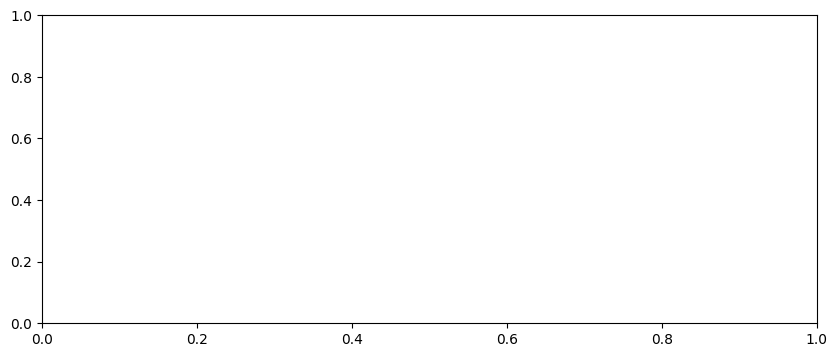

In [8]:
with torch.no_grad():
    src = ExtendedGaussianSource(
        mfd_um=STD_EVAL["mfd_um"],
        divergence_deg_1_e2=STD_EVAL["divergence_deg_1_e2"],
        wavelength_um=STD_EVAL["wavelength_um"],
        device=DEVICE,
    )
    
    emitter.set_source(src)
    emitter.draw()
